In [2]:
!pip install torchsde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.2 MB/s eta 0:00:00


<ipython-input-3-7a6b0824f42e>:102: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  values = torch.tensor(values).detach().numpy()  # Ensure values are detached


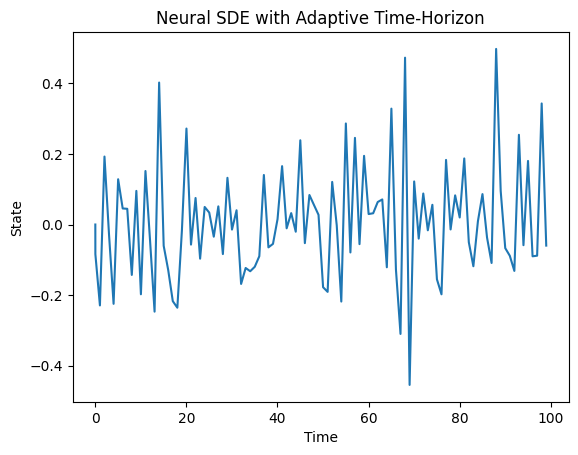

In [3]:
import torch
import torchsde
import torch.nn as nn
import matplotlib.pyplot as plt

# Define the neural networks for drift (f) and diffusion (g)
class DriftNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DriftNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, t, x):
        return self.net(x)

class DiffusionNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DiffusionNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, t, x):
        return self.net(x)

# Define the SDE system
class NeuralSDE(torchsde.SDEIto):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralSDE, self).__init__(noise_type='diagonal')
        self.drift = DriftNet(input_dim, hidden_dim, output_dim)
        self.diffusion = DiffusionNet(input_dim, hidden_dim, output_dim)

    # Drift function f(x, t)
    def f(self, t, x):
        return self.drift(t, x)

    # Diffusion function g(x, t)
    def g(self, t, x):
        return self.diffusion(t, x)

# Define the uncertainty quantification and adaptive time horizon
def uncertainty_quantification(g, g_hat):
    return torch.mean((g - g_hat) ** 2)

def adaptive_time_horizon(T_fixed, uncertainty, alpha=0.5):
    return T_fixed / (1 + alpha * uncertainty)

# Function to simulate and adapt time horizon
def simulate_with_adaptive_horizon(sde_model, x0, T_fixed, time_steps, alpha=0.5):
    times = [0.0]
    values = [x0.detach().numpy()]  # Detach tensor before converting to NumPy
    t = 0.0
    x = x0
    dt = 0.01  # Initial small time step
    for _ in range(time_steps):
        # Simulate one step
        t_next = t + dt
        g_hat = sde_model.g(t, x)  # Get learned diffusion
        g = sde_model.diffusion(t, x)  # Assume it's the real diffusion (for illustration)

        # Compute uncertainty
        uncertainty = uncertainty_quantification(g, g_hat)

        # Adapt time horizon
        dt = adaptive_time_horizon(T_fixed, uncertainty, alpha)

        # Update state using SDE solver (Euler-Maruyama method here)
        x = sde_model.f(t, x) * dt + g_hat * torch.sqrt(dt) * torch.randn_like(x)

        # Store the results
        times.append(t_next)
        values.append(x.detach().numpy())  # Detach tensor before converting to NumPy
        t = t_next

    return times, values

# Main function
if __name__ == "__main__":
    torch.manual_seed(0)

    # Define model and initial conditions
    input_dim = 1
    hidden_dim = 32
    output_dim = 1
    sde_model = NeuralSDE(input_dim, hidden_dim, output_dim)

    x0 = torch.tensor([0.0], requires_grad=True)  # Initial state
    T_fixed = 1.0  # Fixed time horizon
    time_steps = 100  # Number of steps to simulate
    alpha = 0.1  # Scaling factor for adaptive time horizon

    # Simulate SDE with adaptive time horizon
    times, values = simulate_with_adaptive_horizon(sde_model, x0, T_fixed, time_steps, alpha)

    # Convert times and values to NumPy arrays (detaching is already done in simulate_with_adaptive_horizon)
    times = torch.tensor(times).detach().numpy()  # Make sure times are detached
    values = torch.tensor(values).detach().numpy()  # Ensure values are detached

    # Plot the results
    plt.plot(times, values)
    plt.title("Neural SDE with Adaptive Time-Horizon")
    plt.xlabel("Time")
    plt.ylabel("State")
    plt.show()


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchsde
import matplotlib.pyplot as plt

# Define the neural networks for drift (f) and diffusion (g)
class DriftNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DriftNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, t, x):
        return self.net(x)

class DiffusionNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DiffusionNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, t, x):
        return self.net(x)

# Define the Neural SDE model
class NeuralSDE(torchsde.SDEIto):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralSDE, self).__init__(noise_type='diagonal')
        self.drift = DriftNet(input_dim, hidden_dim, output_dim)
        self.diffusion = DiffusionNet(input_dim, hidden_dim, output_dim)

    # Drift function f(x, t)
    def f(self, t, x):
        return self.drift(t, x)

    # Diffusion function g(x, t)
    def g(self, t, x):
        return self.diffusion(t, x)

# Define the physics-constrained loss function
def physics_loss(f_physics, f_model, x):
    """ Penalizes deviation from known physical dynamics """
    return torch.mean((f_physics - f_model) ** 2)

# Define the uncertainty quantification and adaptive time horizon
def uncertainty_quantification(g, g_hat):
    return torch.mean((g - g_hat) ** 2)

def adaptive_time_horizon(T_fixed, uncertainty, alpha=0.5):
    return T_fixed / (1 + alpha * uncertainty)

# Simulate the system with adaptive learning windows
def simulate_with_adaptive_horizon(sde_model, x0, T_fixed, time_steps, alpha=0.5):
    times = [0.0]
    values = [x0.detach().numpy()]  # Detach tensor before converting to NumPy
    t = 0.0
    x = x0
    dt = 0.01  # Initial small time step
    for _ in range(time_steps):
        # Simulate one step
        t_next = t + dt
        g_hat = sde_model.g(t, x)  # Get learned diffusion
        g = sde_model.diffusion(t, x)  # Assume it's the real diffusion (for illustration)

        # Compute uncertainty
        uncertainty = uncertainty_quantification(g, g_hat)

        # Adapt time horizon
        dt = adaptive_time_horizon(T_fixed, uncertainty, alpha)

        # Update state using SDE solver (Euler-Maruyama method here)
        x = sde_model.f(t, x) * dt + g_hat * torch.sqrt(dt) * torch.randn_like(x)

        # Store the results
        times.append(t_next)
        values.append(x.detach().numpy())  # Detach tensor before converting to NumPy
        t = t_next

    return times, values

# Example known physical function for the physics loss
def known_physics_function(x):
    # Example: simple harmonic oscillator (f_physics)
    return -x

# Training loop for Neural SDE
def train_neural_sde(sde_model, x0, T_fixed, epochs, time_steps, optimizer, alpha=0.1):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        sde_model.train()

        # Forward pass with adaptive time horizon
        times, values = simulate_with_adaptive_horizon(sde_model, x0, T_fixed, time_steps, alpha)

        # Compute physics-constrained loss
        f_model = sde_model.f(0.0, x0)
        f_physics = known_physics_function(x0)  # Known physical model
        L_physics = physics_loss(f_physics, f_model, x0)

        # Backpropagation and optimization
        optimizer.zero_grad()
        L_physics.backward()
        optimizer.step()

        # Record train loss
        train_losses.append(L_physics.item())

        # Simulate test (optional)
        with torch.no_grad():
            sde_model.eval()
            test_times, test_values = simulate_with_adaptive_horizon(sde_model, x0, T_fixed, time_steps, alpha)
            test_loss = physics_loss(f_physics, f_model, x0)
            test_losses.append(test_loss.item())

        # Print the loss for the current epoch
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {L_physics.item()}, Test Loss: {test_loss.item()}")

    return train_losses, test_losses

# Main function
if __name__ == "__main__":
    torch.manual_seed(0)

    # Define model and initial conditions
    input_dim = 1
    hidden_dim = 32
    output_dim = 1
    sde_model = NeuralSDE(input_dim, hidden_dim, output_dim)

    x0 = torch.tensor([0.0], requires_grad=True)  # Initial state
    T_fixed = 1.0  # Fixed time horizon
    time_steps = 100  # Number of steps to simulate
    epochs = 50  # Number of epochs
    alpha = 0.1  # Scaling factor for adaptive time horizon

    # Define optimizer
    optimizer = optim.Adam(sde_model.parameters(), lr=0.01)

    # Train the model
    train_losses, test_losses = train_neural_sde(sde_model, x0, T_fixed, epochs, time_steps, optimizer, alpha)




Epoch [1/50], Training Loss: 5.553902155952528e-05, Test Loss: 5.553902155952528e-05
Epoch [2/50], Training Loss: 0.03071746975183487, Test Loss: 0.03071746975183487
Epoch [3/50], Training Loss: 0.0019915287848562002, Test Loss: 0.0019915287848562002
Epoch [4/50], Training Loss: 0.0067299301736056805, Test Loss: 0.0067299301736056805
Epoch [5/50], Training Loss: 0.017527638003230095, Test Loss: 0.017527638003230095
Epoch [6/50], Training Loss: 0.012663313187658787, Test Loss: 0.012663313187658787
Epoch [7/50], Training Loss: 0.003208855167031288, Test Loss: 0.003208855167031288
Epoch [8/50], Training Loss: 0.00010385407222202048, Test Loss: 0.00010385407222202048
Epoch [9/50], Training Loss: 0.004293996840715408, Test Loss: 0.004293996840715408
Epoch [10/50], Training Loss: 0.008530274033546448, Test Loss: 0.008530274033546448
Epoch [11/50], Training Loss: 0.007656256202608347, Test Loss: 0.007656256202608347
Epoch [12/50], Training Loss: 0.0034216337371617556, Test Loss: 0.00342163373

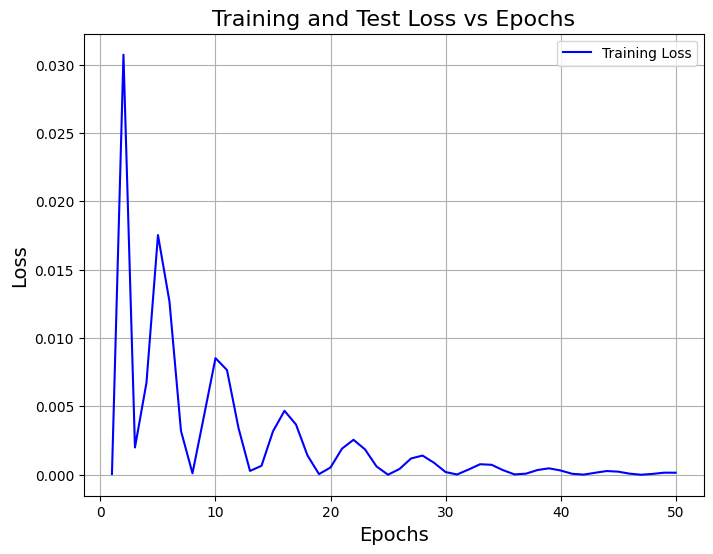

In [5]:
# Plot training  loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), train_losses, label="Training Loss", color='blue')
plt.title("Training and Test Loss vs Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

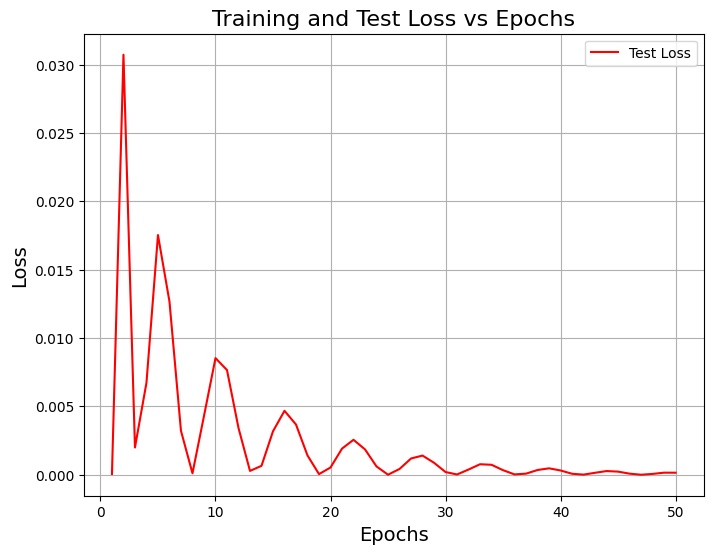

In [6]:
# Plot  test loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color='red')
plt.title("Training and Test Loss vs Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()